In [1]:
cd ..

/Users/muhammadfarooq/Codebase/thesis-experiment/Pith2Bark


In [2]:
from src.winner import winner_model_rings
from src.damage import merge_df
from src.damage import read_damage_min_max
from src.damage import read_damage_mean

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import unique

from tensorflow.keras.layers import Conv1D, Dense, MaxPool1D, MaxPooling1D, Dropout, Flatten
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

from keras.layers import BatchNormalization

2023-04-05 14:02:54.911898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import warnings
warnings.simplefilter('ignore')

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

random_state = 47
np.random.seed(random_state)

# Visual

In [5]:
def plot_loss(history, label, n):
    plt.semilogy(history.epoch, history.history['loss'],
                 color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
                 color=colors[n], label='Val ' + label,
                 linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        plt.legend()

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

# Configuration

In [6]:
epochs, batch_size = 50, 32
# 50, 32
# 500, 50
kf = KFold(n_splits=3, shuffle=True, random_state=42)

accuracy_sixteen_min_max = []
accuracy_thirtytwo_min_max = []
accuracy_sixteen_mean = []
accuracy_thirtytwo_mean = []

# mode = max for monitro val_accuracy and val_prc

early_stopping = EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

#columns to drop
columns = ['image', 'algo']

2023-04-05 14:02:59.752660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Prepare Dataset

In [7]:
mse_url = "output/ringsranking_mse_sixteen.csv"
rings_url = "output/ringsranking_rings_sixteen.csv"
df_ringsranking_sixteen = winner_model_rings(mse_url, rings_url)

mse_url = "output/ringsranking_mse_thirtytwo.csv"
rings_url = "output/ringsranking_rings_thirtytwo.csv"
df_ringsranking_thirtytwo = winner_model_rings(mse_url, rings_url)

Polar Pith Canny(blur otsu) 12.829318845239923 (subseq)
Polar Pith Canny(blur otsu) 12.88055458721076 (subseq)


In [8]:
mse_url = "output/pine_mse_sixteen.csv"
rings_url = "output/pine_rings_sixteen.csv"
df_pine_sixteen = winner_model_rings(mse_url, rings_url)

mse_url = "output/pine_mse_thirtytwo.csv"
rings_url = "output/pine_rings_thirtytwo.csv"
df_pine_thirtytwo = winner_model_rings(mse_url, rings_url)

Polar Pith Canny(blur triangle) 19.888455438324574 (peaks)
Polar Pith Canny(blur triangle) 19.591747084408897 (peaks)


In [9]:
mse_url = "output/fur_mse_sixteen.csv"
rings_url = "output/fur_rings_sixteen.csv"
df_fur_sixteen = winner_model_rings(mse_url, rings_url)

mse_url = "output/fur_mse_thirtytwo.csv"
rings_url = "output/fur_rings_thirtytwo.csv"
df_fur_thirtytwo = winner_model_rings(mse_url, rings_url)

Polar Pith Canny(blur triangle) 13.428984012468806 (peaks)
Polar Pith Canny(blur triangle) 13.688767879960144 (peaks)


In [10]:
mse_url = "output/tracy_mse_sixteen.csv"
rings_url = "output/tracy_rings_sixteen.csv"
df_tracy_sixteen = winner_model_rings(mse_url, rings_url)

mse_url = "output/tracy_mse_thirtytwo.csv"
rings_url = "output/tracy_rings_thirtytwo.csv"
df_tracy_thirtytwo = winner_model_rings(mse_url, rings_url)

Polar Canny(triangle) 39.683736416974455 (peaks)
Polar Pith Canny(triangle) 39.48914666858598 (peaks)


In [11]:
mse_url = "output/data_mse_sixteen.csv"
rings_url = "output/data_rings_sixteen.csv"
df_data_sixteen = winner_model_rings(mse_url, rings_url)

mse_url = "output/data_mse_thirtytwo.csv"
rings_url = "output/data_rings_thirtytwo.csv"
df_data_thirtytwo = winner_model_rings(mse_url, rings_url)

Canny(triangle) 18.789996216404624 (subseq)
Canny(triangle) 18.871624925897343 (subseq)


In [12]:
#damage
damage_sixteen_url = "damage/damage_sixteen.csv"
damage_thirtytwo_url = "damage/damage_thirtytwo.csv"

#merge
df_merge_sixteen = merge_df(df_ringsranking_sixteen, df_pine_sixteen, df_fur_sixteen, df_tracy_sixteen, df_data_sixteen)
df_merge_thirtytwo = merge_df(df_ringsranking_thirtytwo, df_pine_thirtytwo, df_fur_thirtytwo, df_tracy_thirtytwo, df_data_thirtytwo)

df_damage_sixteen_min_max = read_damage_min_max(damage_sixteen_url, df_merge_sixteen)
df_damage_thirtytwo_min_max = read_damage_min_max(damage_thirtytwo_url, df_merge_thirtytwo)

df_damage_sixteen_mean = read_damage_mean(damage_sixteen_url, df_merge_sixteen)
df_damage_thirtytwo_mean = read_damage_mean(damage_thirtytwo_url, df_merge_thirtytwo)

In [13]:
#df_damage_sixteen_min_max

In [14]:
#df_damage_thirtytwo_min_max

In [15]:
#df_damage_sixteen_mean

In [16]:
#df_damage_thirtytwo_mean

In [17]:
#STOP

# Dense Model

In [18]:
def layerFactory(type, nodes, activation):
        if type == 'Dense':
            if not activation:
                return Dense(units=nodes)
            else:
                return Dense(units=nodes, activation=activation)
        if type == 'Conv1D':
            if not activation:
                return Conv1D(units=nodes)
            else:
                return Conv1D(units=nodes, activation=activation)
        if type == 'MaxPooling1D':
            if not activation:
                return MaxPooling1D(units=nodes)
            else:
                return MaxPooling1D(units=nodes, activation=activation)
        if type == 'Dropout':
            return Dropout(rate=nodes)
        if type == 'Flatten':
            if not activation:
                return Flatten(units=nodes)
            else:
                return Flatten(units=nodes, activation=activation)

        return Dense(units=nodes, activation=activation)

In [19]:
class DenseModel():
    def __init__(self, layers, input_dim, metrics=METRICS, output_bias=None):
        if output_bias is not None:
            output_bias = tf.keras.initializers.Constant(output_bias)

        model = Sequential([
            InputLayer(input_shape=(input_dim))
        ])

        for layer in layers:
            model.add(layerFactory(layer['type'], layer['nodes'], layer['activation']))

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=metrics)
        
        self.model = model
    
    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, callback):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, callbacks=[callback])
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X): #X_train X_test
        predictions = self.model.predict(X)
        return predictions
    
    def summary(self):
        self.model.summary()
        
    def metrics_names(self):
        return self.model.metrics_names

## 1 Dense Model with 16 Lines

### Dataset

In [20]:
# prepare dataset
df = df_damage_sixteen_min_max.drop(columns=columns)

In [21]:
# Split into sets for training, validation, and testing + use and save scaler

X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 20)
Training labels shape: (106,) 

Validation features shape: (27, 20)
Validation labels shape: (27,) 

Test features shape: (15, 20)
Test labels shape: (15,) 



### Model

In [22]:
input_dim = X_train.shape[1]
units = 16
activation = 'relu'
output_size = 1
output_activation = 'sigmoid'
kernel_initializer = 'he_uniform'

LAYERS = [ 
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':output_size, 'activation': output_activation }
]

model = DenseModel(LAYERS, input_dim)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                336       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping)
#plt.plot(history.history['loss'])
#plt.show()

Epoch 1/50
4/4 [==============================] - 2s 185ms/step - loss: 0.5203 - tp: 36.0000 - fp: 11.0000 - tn: 57.0000 - fn: 2.0000 - accuracy: 0.8774 - precision: 0.7660 - recall: 0.9474 - auc: 0.9783 - prc: 0.9655 - val_loss: 0.5518 - val_tp: 9.0000 - val_fp: 5.0000 - val_tn: 12.0000 - val_fn: 1.0000 - val_accuracy: 0.7778 - val_precision: 0.6429 - val_recall: 0.9000 - val_auc: 0.9000 - val_prc: 0.9358
Epoch 2/50
4/4 [==============================] - 0s 17ms/step - loss: 0.5143 - tp: 36.0000 - fp: 10.0000 - tn: 58.0000 - fn: 2.0000 - accuracy: 0.8868 - precision: 0.7826 - recall: 0.9474 - auc: 0.9783 - prc: 0.9650 - val_loss: 0.5435 - val_tp: 9.0000 - val_fp: 5.0000 - val_tn: 12.0000 - val_fn: 1.0000 - val_accuracy: 0.7778 - val_precision: 0.6429 - val_recall: 0.9000 - val_auc: 0.9000 - val_prc: 0.9358
Epoch 3/50
4/4 [==============================] - 0s 17ms/step - loss: 0.5084 - tp: 36.0000 - fp: 9.0000 - tn: 59.0000 - fn: 2.0000 - accuracy: 0.8962 - precision: 0.8000 - recall: 

4/4 [==============================] - 0s 16ms/step - loss: 0.4205 - tp: 35.0000 - fp: 5.0000 - tn: 63.0000 - fn: 3.0000 - accuracy: 0.9245 - precision: 0.8750 - recall: 0.9211 - auc: 0.9820 - prc: 0.9674 - val_loss: 0.4202 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 1.0000 - val_accuracy: 0.8889 - val_precision: 0.8182 - val_recall: 0.9000 - val_auc: 0.9059 - val_prc: 0.9372
Epoch 22/50
4/4 [==============================] - 0s 17ms/step - loss: 0.4168 - tp: 35.0000 - fp: 5.0000 - tn: 63.0000 - fn: 3.0000 - accuracy: 0.9245 - precision: 0.8750 - recall: 0.9211 - auc: 0.9814 - prc: 0.9667 - val_loss: 0.4156 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 1.0000 - val_accuracy: 0.8889 - val_precision: 0.8182 - val_recall: 0.9000 - val_auc: 0.9059 - val_prc: 0.9372
Epoch 23/50
4/4 [==============================] - 0s 17ms/step - loss: 0.4131 - tp: 35.0000 - fp: 5.0000 - tn: 63.0000 - fn: 3.0000 - accuracy: 0.9245 - precision: 0.8750 - recall: 0.9211 - auc

4/4 [==============================] - 0s 17ms/step - loss: 0.3601 - tp: 33.0000 - fp: 5.0000 - tn: 63.0000 - fn: 5.0000 - accuracy: 0.9057 - precision: 0.8684 - recall: 0.8684 - auc: 0.9760 - prc: 0.9613 - val_loss: 0.3516 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 1.0000 - val_accuracy: 0.8889 - val_precision: 0.8182 - val_recall: 0.9000 - val_auc: 0.9235 - val_prc: 0.9422
Epoch 42/50
4/4 [==============================] - 0s 18ms/step - loss: 0.3578 - tp: 33.0000 - fp: 5.0000 - tn: 63.0000 - fn: 5.0000 - accuracy: 0.9057 - precision: 0.8684 - recall: 0.8684 - auc: 0.9758 - prc: 0.9610 - val_loss: 0.3492 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 1.0000 - val_accuracy: 0.8889 - val_precision: 0.8182 - val_recall: 0.9000 - val_auc: 0.9235 - val_prc: 0.9422
Epoch 43/50
4/4 [==============================] - 0s 19ms/step - loss: 0.3555 - tp: 33.0000 - fp: 5.0000 - tn: 63.0000 - fn: 5.0000 - accuracy: 0.9057 - precision: 0.8684 - recall: 0.8684 - auc

In [24]:
early_stopping.stopped_epoch

0

In [25]:
#plot_loss(history, "Bias", 0)
#plt.show()

In [26]:
#plot_metrics(history)
#plt.show()

In [27]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names(), results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_sixteen_min_max.append(value)

1/1 [==============================] - 0s 20ms/step
loss :  0.26257196068763733
tp :  5.0
fp :  0.0
tn :  9.0
fn :  1.0
accuracy :  0.9333333373069763
precision :  1.0
recall :  0.8333333134651184
auc :  0.9814814329147339
prc :  0.9743082523345947


True Negatives:  9
False Positives:  0
False Negatives:  1
True Positives:  5
Total:  6


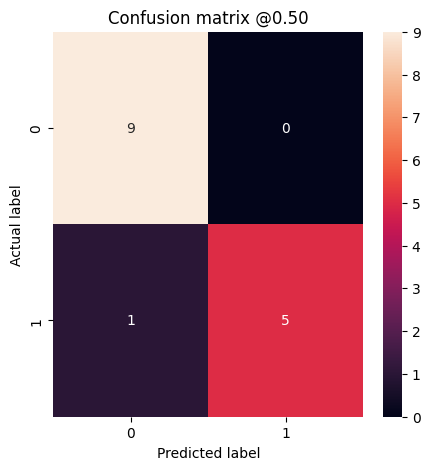

In [28]:
plot_cm(y_test, predictions_test)
plt.show()

In [29]:
#plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [30]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [31]:
#STOP

## 2 Dense Model with 32 Lines

### Dataset

In [32]:
df = df_damage_thirtytwo_min_max.drop(columns=columns)

In [33]:
# Split into sets for training, validation, and testing + use and save scaler

X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 36)
Training labels shape: (106,) 

Validation features shape: (27, 36)
Validation labels shape: (27,) 

Test features shape: (15, 36)
Test labels shape: (15,) 



### Model

In [34]:
input_dim = X_train.shape[1]
units = 16
activation = 'relu'
output_size = 1
output_activation = 'sigmoid'
kernel_initializer = 'he_uniform'

LAYERS = [ 
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':output_size, 'activation': output_activation }
]

model = DenseModel(LAYERS, input_dim)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                592       
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping)
#plt.plot(history.history['loss'])
#plt.show()

Epoch 1/50
4/4 [==============================] - 2s 157ms/step - loss: 0.8012 - tp: 39.0000 - fp: 59.0000 - tn: 11.0000 - fn: 12.0000 - accuracy: 0.4132 - precision: 0.3980 - recall: 0.7647 - auc: 0.4338 - prc: 0.4439 - val_loss: 0.8086 - val_tp: 9.0000 - val_fp: 14.0000 - val_tn: 0.0000e+00 - val_fn: 4.0000 - val_accuracy: 0.3333 - val_precision: 0.3913 - val_recall: 0.6923 - val_auc: 0.2665 - val_prc: 0.3521
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 0.7918 - tp: 34.0000 - fp: 59.0000 - tn: 2.0000 - fn: 11.0000 - accuracy: 0.3396 - precision: 0.3656 - recall: 0.7556 - auc: 0.3164 - prc: 0.3233 - val_loss: 0.7972 - val_tp: 9.0000 - val_fp: 14.0000 - val_tn: 0.0000e+00 - val_fn: 4.0000 - val_accuracy: 0.3333 - val_precision: 0.3913 - val_recall: 0.6923 - val_auc: 0.2885 - val_prc: 0.3636
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 0.7823 - tp: 35.0000 - fp: 59.0000 - tn: 2.0000 - fn: 10.0000 - accuracy: 0.3491 - precision: 0.3723 

Epoch 21/50
4/4 [==============================] - 0s 16ms/step - loss: 0.6507 - tp: 41.0000 - fp: 54.0000 - tn: 7.0000 - fn: 4.0000 - accuracy: 0.4528 - precision: 0.4316 - recall: 0.9111 - auc: 0.7760 - prc: 0.8031 - val_loss: 0.6396 - val_tp: 11.0000 - val_fp: 13.0000 - val_tn: 1.0000 - val_fn: 2.0000 - val_accuracy: 0.4444 - val_precision: 0.4583 - val_recall: 0.8462 - val_auc: 0.7005 - val_prc: 0.7818
Epoch 22/50
4/4 [==============================] - 0s 16ms/step - loss: 0.6448 - tp: 41.0000 - fp: 52.0000 - tn: 9.0000 - fn: 4.0000 - accuracy: 0.4717 - precision: 0.4409 - recall: 0.9111 - auc: 0.7913 - prc: 0.8151 - val_loss: 0.6335 - val_tp: 11.0000 - val_fp: 12.0000 - val_tn: 2.0000 - val_fn: 2.0000 - val_accuracy: 0.4815 - val_precision: 0.4783 - val_recall: 0.8462 - val_auc: 0.7280 - val_prc: 0.8077
Epoch 23/50
4/4 [==============================] - 0s 16ms/step - loss: 0.6387 - tp: 41.0000 - fp: 51.0000 - tn: 10.0000 - fn: 4.0000 - accuracy: 0.4811 - precision: 0.4457 - recal

Epoch 41/50
4/4 [==============================] - 0s 16ms/step - loss: 0.5326 - tp: 41.0000 - fp: 16.0000 - tn: 45.0000 - fn: 4.0000 - accuracy: 0.8113 - precision: 0.7193 - recall: 0.9111 - auc: 0.9224 - prc: 0.9254 - val_loss: 0.5221 - val_tp: 10.0000 - val_fp: 2.0000 - val_tn: 12.0000 - val_fn: 3.0000 - val_accuracy: 0.8148 - val_precision: 0.8333 - val_recall: 0.7692 - val_auc: 0.8022 - val_prc: 0.8733
Epoch 42/50
4/4 [==============================] - 0s 15ms/step - loss: 0.5270 - tp: 41.0000 - fp: 13.0000 - tn: 48.0000 - fn: 4.0000 - accuracy: 0.8396 - precision: 0.7593 - recall: 0.9111 - auc: 0.9231 - prc: 0.9252 - val_loss: 0.5168 - val_tp: 10.0000 - val_fp: 2.0000 - val_tn: 12.0000 - val_fn: 3.0000 - val_accuracy: 0.8148 - val_precision: 0.8333 - val_recall: 0.7692 - val_auc: 0.8049 - val_prc: 0.8741
Epoch 43/50
4/4 [==============================] - 0s 16ms/step - loss: 0.5212 - tp: 41.0000 - fp: 12.0000 - tn: 49.0000 - fn: 4.0000 - accuracy: 0.8491 - precision: 0.7736 - rec

In [36]:
early_stopping.stopped_epoch

0

In [37]:
#plot_loss(history, "Bias", 0)
#plt.show()

In [38]:
#plot_metrics(history)
#plt.show()

In [39]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names(), results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_thirtytwo_min_max.append(value)

1/1 [==============================] - 0s 22ms/step
loss :  0.4108259379863739
tp :  5.0
fp :  1.0
tn :  8.0
fn :  1.0
accuracy :  0.8666666746139526
precision :  0.8333333134651184
recall :  0.8333333134651184
auc :  0.9814814925193787
prc :  0.9743082523345947


True Negatives:  8
False Positives:  1
False Negatives:  1
True Positives:  5
Total:  6


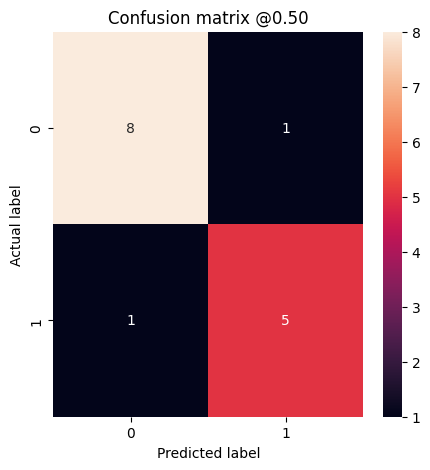

In [40]:
plot_cm(y_test, predictions_test)
plt.show()

In [41]:
#plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [42]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [43]:
#STOP

## 3 Dense Model with 16 Lines

### Dataset

In [44]:
# prepare dataset

df = df_damage_sixteen_mean.drop(columns=columns)

In [45]:
# Split into sets for training, validation, and testing + use and save scaler

X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 20)
Training labels shape: (106,) 

Validation features shape: (27, 20)
Validation labels shape: (27,) 

Test features shape: (15, 20)
Test labels shape: (15,) 



### Model

In [46]:
input_dim = X_train.shape[1]
units = 16
activation = 'relu'
output_size = 1
output_activation = 'sigmoid'
kernel_initializer = 'he_uniform'

LAYERS = [ 
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':output_size, 'activation': output_activation }
]

model = DenseModel(LAYERS, input_dim)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                336       
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping)
#plt.plot(history.history['loss'])
#plt.show()

Epoch 1/50
4/4 [==============================] - 2s 219ms/step - loss: 0.7271 - tp: 9.0000 - fp: 8.0000 - tn: 59.0000 - fn: 45.0000 - accuracy: 0.5620 - precision: 0.5294 - recall: 0.1667 - auc: 0.5312 - prc: 0.5465 - val_loss: 0.6738 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 9.0000 - val_accuracy: 0.5926 - val_precision: 0.3333 - val_recall: 0.1000 - val_auc: 0.5529 - val_prc: 0.3912
Epoch 2/50
4/4 [==============================] - 0s 24ms/step - loss: 0.7253 - tp: 4.0000 - fp: 7.0000 - tn: 51.0000 - fn: 44.0000 - accuracy: 0.5189 - precision: 0.3636 - recall: 0.0833 - auc: 0.4657 - prc: 0.4553 - val_loss: 0.6718 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 9.0000 - val_accuracy: 0.5926 - val_precision: 0.3333 - val_recall: 0.1000 - val_auc: 0.5647 - val_prc: 0.3966
Epoch 3/50
4/4 [==============================] - 0s 25ms/step - loss: 0.7238 - tp: 3.0000 - fp: 7.0000 - tn: 51.0000 - fn: 45.0000 - accuracy: 0.5094 - precision: 0.3000 - recall: 0.

4/4 [==============================] - 0s 16ms/step - loss: 0.7000 - tp: 5.0000 - fp: 7.0000 - tn: 51.0000 - fn: 43.0000 - accuracy: 0.5283 - precision: 0.4167 - recall: 0.1042 - auc: 0.5392 - prc: 0.5098 - val_loss: 0.6447 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 9.0000 - val_accuracy: 0.5926 - val_precision: 0.3333 - val_recall: 0.1000 - val_auc: 0.6147 - val_prc: 0.4194
Epoch 22/50
4/4 [==============================] - 0s 16ms/step - loss: 0.6989 - tp: 5.0000 - fp: 7.0000 - tn: 51.0000 - fn: 43.0000 - accuracy: 0.5283 - precision: 0.4167 - recall: 0.1042 - auc: 0.5427 - prc: 0.5116 - val_loss: 0.6434 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 9.0000 - val_accuracy: 0.5926 - val_precision: 0.3333 - val_recall: 0.1000 - val_auc: 0.6206 - val_prc: 0.4230
Epoch 23/50
4/4 [==============================] - 0s 15ms/step - loss: 0.6978 - tp: 5.0000 - fp: 7.0000 - tn: 51.0000 - fn: 43.0000 - accuracy: 0.5283 - precision: 0.4167 - recall: 0.1042 - auc

4/4 [==============================] - 0s 16ms/step - loss: 0.6804 - tp: 6.0000 - fp: 6.0000 - tn: 52.0000 - fn: 42.0000 - accuracy: 0.5472 - precision: 0.5000 - recall: 0.1250 - auc: 0.5995 - prc: 0.5539 - val_loss: 0.6234 - val_tp: 2.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 8.0000 - val_accuracy: 0.6296 - val_precision: 0.5000 - val_recall: 0.2000 - val_auc: 0.6618 - val_prc: 0.4544
Epoch 42/50
4/4 [==============================] - 0s 16ms/step - loss: 0.6798 - tp: 7.0000 - fp: 6.0000 - tn: 52.0000 - fn: 41.0000 - accuracy: 0.5566 - precision: 0.5385 - recall: 0.1458 - auc: 0.5995 - prc: 0.5578 - val_loss: 0.6223 - val_tp: 2.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 8.0000 - val_accuracy: 0.6296 - val_precision: 0.5000 - val_recall: 0.2000 - val_auc: 0.6618 - val_prc: 0.4520
Epoch 43/50
4/4 [==============================] - 0s 16ms/step - loss: 0.6788 - tp: 7.0000 - fp: 6.0000 - tn: 52.0000 - fn: 41.0000 - accuracy: 0.5566 - precision: 0.5385 - recall: 0.1458 - auc

In [48]:
early_stopping.stopped_epoch

0

In [49]:
#plot_loss(history, "Bias", 0)
#plt.show()

In [50]:
#plot_metrics(history)
#plt.show()

In [51]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names(), results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_sixteen_mean.append(value)

1/1 [==============================] - 0s 20ms/step
loss :  0.7403993010520935
tp :  1.0
fp :  2.0
tn :  5.0
fn :  7.0
accuracy :  0.4000000059604645
precision :  0.3333333432674408
recall :  0.125
auc :  0.5357142686843872
prc :  0.5007680654525757


True Negatives:  5
False Positives:  2
False Negatives:  7
True Positives:  1
Total:  8


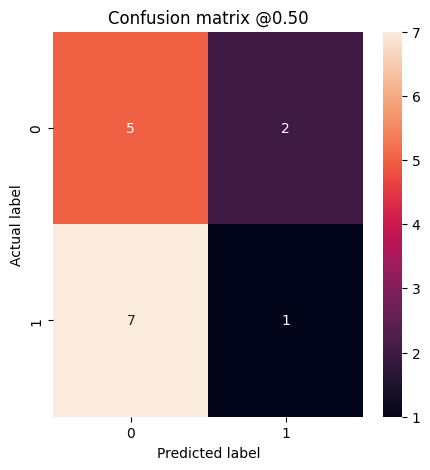

In [52]:
plot_cm(y_test, predictions_test)
plt.show()

In [53]:
#plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [54]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [55]:
#STOP

## 4 Dense Model with 32 Lines

### Dataset

In [56]:
# prepare dataset

df = df_damage_thirtytwo_mean.drop(columns=columns)

In [57]:
# Split into sets for training, validation, and testing + use and save scaler

X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 36)
Training labels shape: (106,) 

Validation features shape: (27, 36)
Validation labels shape: (27,) 

Test features shape: (15, 36)
Test labels shape: (15,) 



### Model

In [58]:
input_dim = X_train.shape[1]
units = 16
activation = 'relu'
output_size = 1
output_activation = 'sigmoid'
kernel_initializer = 'he_uniform'

LAYERS = [ 
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':output_size, 'activation': output_activation }
]

model = DenseModel(LAYERS, input_dim)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16)                592       
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping)
#plt.plot(history.history['loss'])
#plt.show()

Epoch 1/50
4/4 [==============================] - 2s 142ms/step - loss: 0.6628 - tp: 27.0000 - fp: 21.0000 - tn: 43.0000 - fn: 30.0000 - accuracy: 0.5785 - precision: 0.5625 - recall: 0.4737 - auc: 0.6430 - prc: 0.6089 - val_loss: 0.5630 - val_tp: 7.0000 - val_fp: 4.0000 - val_tn: 12.0000 - val_fn: 4.0000 - val_accuracy: 0.7037 - val_precision: 0.6364 - val_recall: 0.6364 - val_auc: 0.7784 - val_prc: 0.7183
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 0.6615 - tp: 26.0000 - fp: 19.0000 - tn: 38.0000 - fn: 23.0000 - accuracy: 0.6038 - precision: 0.5778 - recall: 0.5306 - auc: 0.6584 - prc: 0.6116 - val_loss: 0.5632 - val_tp: 7.0000 - val_fp: 4.0000 - val_tn: 12.0000 - val_fn: 4.0000 - val_accuracy: 0.7037 - val_precision: 0.6364 - val_recall: 0.6364 - val_auc: 0.7784 - val_prc: 0.7183
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 0.6606 - tp: 26.0000 - fp: 19.0000 - tn: 38.0000 - fn: 23.0000 - accuracy: 0.6038 - precision: 0.5778 - reca

In [60]:
early_stopping.stopped_epoch

10

In [61]:
#plot_loss(history, "Bias", 0)
#plt.show()

In [62]:
#plot_metrics(history)
#plt.show()

In [63]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names(), results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_thirtytwo_mean.append(value)

1/1 [==============================] - 0s 19ms/step
loss :  1.0216046571731567
tp :  1.0
fp :  4.0
tn :  3.0
fn :  7.0
accuracy :  0.2666666805744171
precision :  0.20000000298023224
recall :  0.125
auc :  0.3214285373687744
prc :  0.41036784648895264


True Negatives:  3
False Positives:  4
False Negatives:  7
True Positives:  1
Total:  8


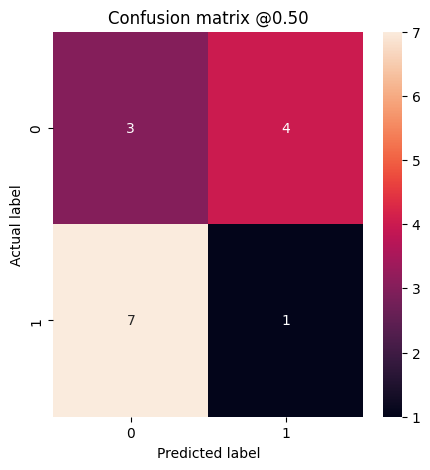

In [64]:
plot_cm(y_test, predictions_test)
plt.show()

In [65]:
#plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [66]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [67]:
#STOP

# 2 CNN Model

In [68]:
class CNNModel():
    def __init__(self, in_shape, n_classes, kernel_size=3, kernel_initializer='he_uniform', activation = 'relu', output_activation = 'sigmoid', pool_size=2, filters_1=8, filters_2=16, filters_3=32, filters_4=12, metrics=METRICS):
        model = Sequential()
        model.add(Conv1D(filters= filters_1, kernel_size = kernel_size, activation=activation, kernel_initializer=kernel_initializer, input_shape=in_shape))

        model.add(Conv1D(filters= filters_2, kernel_size = kernel_size, activation=activation, kernel_initializer=kernel_initializer))
        model.add(MaxPool1D(pool_size=pool_size))
        model.add(Dropout(0.5))

        #model.add(Conv1D(filters= filters_3, kernel_size = kernel_size, activation=activation, kernel_initializer=kernel_initializer))
        #model.add(MaxPool1D(pool_size=pool_size))
        #model.add(Dropout(0.5))

        model.add(Flatten())
        #model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        #model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
        #model.add(Dropout(0.5))
        #model.add(BatchNormalization())
        model.add(Dense(n_classes, activation=output_activation)) #'softmax'

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=metrics)
        
        self.model = model    

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, callback):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, callbacks=[callback])
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X): #X_train X_test
        predictions = self.model.predict(X)
        return predictions
    
    def summary(self):
        self.model.summary()
        
    def metrics_names(self):
        return self.model.metrics_names
        

## 5 CNN Model with 16 Lines

### Dataset

In [69]:
# prepare dataset

df = df_damage_sixteen_min_max.drop(columns=columns)

In [70]:
# Split into sets for training, validation, and testing + use and save scaler

X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 20)
Training labels shape: (106,) 

Validation features shape: (27, 20)
Validation labels shape: (27,) 

Test features shape: (15, 20)
Test labels shape: (15,) 



### Model

In [71]:
orig_shape = X_train.shape[1:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

in_shape = X_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))

n_classes = len(unique(y_train))
n_classes = 1
print("Classes: {0}".format(n_classes))

model = CNNModel(in_shape, n_classes)
model.summary()

Before: (20,)
After: (20, 1)
Classes: 1
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 8)             32        
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 16)            400       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 16)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 8, 16)             0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 8)                 1032      
              

In [72]:
history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping)
#plt.plot(history.history['loss'])
#plt.show()

Epoch 1/50
4/4 [==============================] - 2s 159ms/step - loss: 1.8476 - tp: 10.0000 - fp: 39.0000 - tn: 36.0000 - fn: 36.0000 - accuracy: 0.3802 - precision: 0.2041 - recall: 0.2174 - auc: 0.2849 - prc: 0.3040 - val_loss: 2.4513 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 17.0000 - val_fn: 10.0000 - val_accuracy: 0.6296 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0294 - val_prc: 0.2147
Epoch 2/50
4/4 [==============================] - 0s 17ms/step - loss: 1.7363 - tp: 9.0000 - fp: 23.0000 - tn: 45.0000 - fn: 29.0000 - accuracy: 0.5094 - precision: 0.2812 - recall: 0.2368 - auc: 0.2848 - prc: 0.3161 - val_loss: 2.3906 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 17.0000 - val_fn: 10.0000 - val_accuracy: 0.6296 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0294 - val_prc: 0.2147
Epoch 3/50
4/4 [==============================] - 0s 17ms/step - loss: 1.7185 - tp: 10.0000 - fp: 23.0000 - tn: 45.0000 - fn: 28.0000 - accuracy: 

4/4 [==============================] - 0s 19ms/step - loss: 1.0171 - tp: 15.0000 - fp: 18.0000 - tn: 50.0000 - fn: 23.0000 - accuracy: 0.6132 - precision: 0.4545 - recall: 0.3947 - auc: 0.4814 - prc: 0.5116 - val_loss: 1.3766 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 17.0000 - val_fn: 10.0000 - val_accuracy: 0.6296 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0971 - val_prc: 0.2233
Epoch 21/50
4/4 [==============================] - 0s 17ms/step - loss: 1.1922 - tp: 11.0000 - fp: 22.0000 - tn: 46.0000 - fn: 27.0000 - accuracy: 0.5377 - precision: 0.3333 - recall: 0.2895 - auc: 0.3957 - prc: 0.3922 - val_loss: 1.3236 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 17.0000 - val_fn: 10.0000 - val_accuracy: 0.6296 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1088 - val_prc: 0.2248
Epoch 22/50
4/4 [==============================] - 0s 31ms/step - loss: 1.3551 - tp: 11.0000 - fp: 22.0000 - tn: 46.0000 - fn: 27.0000 - accuracy: 0.5377 - 

4/4 [==============================] - 0s 17ms/step - loss: 1.0585 - tp: 17.0000 - fp: 18.0000 - tn: 50.0000 - fn: 21.0000 - accuracy: 0.6321 - precision: 0.4857 - recall: 0.4474 - auc: 0.5197 - prc: 0.5637 - val_loss: 0.6107 - val_tp: 3.0000 - val_fp: 0.0000e+00 - val_tn: 17.0000 - val_fn: 7.0000 - val_accuracy: 0.7407 - val_precision: 1.0000 - val_recall: 0.3000 - val_auc: 0.7206 - val_prc: 0.7506
Epoch 40/50
4/4 [==============================] - 0s 16ms/step - loss: 1.1009 - tp: 10.0000 - fp: 16.0000 - tn: 52.0000 - fn: 28.0000 - accuracy: 0.5849 - precision: 0.3846 - recall: 0.2632 - auc: 0.3913 - prc: 0.4265 - val_loss: 0.5835 - val_tp: 3.0000 - val_fp: 0.0000e+00 - val_tn: 17.0000 - val_fn: 7.0000 - val_accuracy: 0.7407 - val_precision: 1.0000 - val_recall: 0.3000 - val_auc: 0.7529 - val_prc: 0.7900
Epoch 41/50
4/4 [==============================] - 0s 17ms/step - loss: 0.8552 - tp: 17.0000 - fp: 19.0000 - tn: 49.0000 - fn: 21.0000 - accuracy: 0.6226 - precision: 0.4722 - recall

In [73]:
early_stopping.stopped_epoch

0

In [74]:
#plot_loss(history, "Bias", 0)
#plt.show()

In [75]:
#plot_metrics(history)
#plt.show()

In [76]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names(), results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_sixteen_min_max.append(value)

1/1 [==============================] - 0s 27ms/step
loss :  0.36068207025527954
tp :  4.0
fp :  0.0
tn :  9.0
fn :  2.0
accuracy :  0.8666666746139526
precision :  1.0
recall :  0.6666666865348816
auc :  0.8888888359069824
prc :  0.9129886031150818


True Negatives:  9
False Positives:  0
False Negatives:  2
True Positives:  4
Total:  6


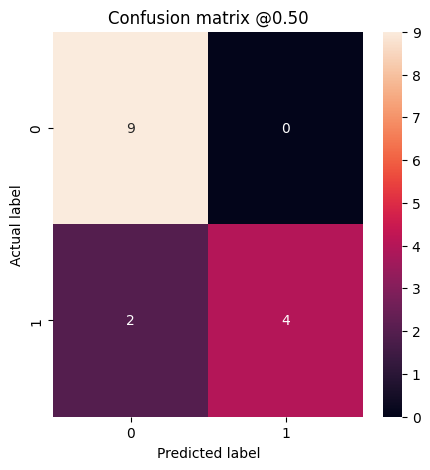

In [77]:
plot_cm(y_test, predictions_test)
plt.show()

In [78]:
#plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [79]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [80]:
#STOP

## 6 CNN Model with 32 Lines

### Dataset

In [81]:
# prepare dataset

df = df_damage_thirtytwo_min_max.drop(columns=columns)

In [82]:
# Split into sets for training, validation, and testing + use and save scaler

X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 36)
Training labels shape: (106,) 

Validation features shape: (27, 36)
Validation labels shape: (27,) 

Test features shape: (15, 36)
Test labels shape: (15,) 



### Model

In [83]:
orig_shape = X_train.shape[1:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

in_shape = X_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))

n_classes = len(unique(y_train))
n_classes = 1
print("Classes: {0}".format(n_classes))

model = CNNModel(in_shape, n_classes)
model.summary()

Before: (36,)
After: (36, 1)
Classes: 1
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 34, 8)             32        
                                                                 
 conv1d_3 (Conv1D)           (None, 32, 16)            400       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 16, 16)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16)            0         
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 8)                 2056      
              

In [84]:
history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping)
#plt.plot(history.history['loss'])
#plt.show()

Epoch 1/50
4/4 [==============================] - 2s 193ms/step - loss: 0.8525 - tp: 27.0000 - fp: 39.0000 - tn: 31.0000 - fn: 24.0000 - accuracy: 0.4793 - precision: 0.4091 - recall: 0.5294 - auc: 0.4653 - prc: 0.4098 - val_loss: 0.8182 - val_tp: 8.0000 - val_fp: 12.0000 - val_tn: 2.0000 - val_fn: 5.0000 - val_accuracy: 0.3704 - val_precision: 0.4000 - val_recall: 0.6154 - val_auc: 0.2033 - val_prc: 0.3289
Epoch 2/50
4/4 [==============================] - 0s 22ms/step - loss: 0.9235 - tp: 19.0000 - fp: 43.0000 - tn: 18.0000 - fn: 26.0000 - accuracy: 0.3491 - precision: 0.3065 - recall: 0.4222 - auc: 0.2885 - prc: 0.3053 - val_loss: 0.8040 - val_tp: 8.0000 - val_fp: 12.0000 - val_tn: 2.0000 - val_fn: 5.0000 - val_accuracy: 0.3704 - val_precision: 0.4000 - val_recall: 0.6154 - val_auc: 0.2143 - val_prc: 0.3318
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 0.9293 - tp: 23.0000 - fp: 48.0000 - tn: 13.0000 - fn: 22.0000 - accuracy: 0.3396 - precision: 0.3239 - reca

Epoch 21/50
4/4 [==============================] - 0s 18ms/step - loss: 0.6942 - tp: 17.0000 - fp: 23.0000 - tn: 38.0000 - fn: 28.0000 - accuracy: 0.5189 - precision: 0.4250 - recall: 0.3778 - auc: 0.5603 - prc: 0.4609 - val_loss: 0.6249 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 13.0000 - val_fn: 4.0000 - val_accuracy: 0.8148 - val_precision: 0.9000 - val_recall: 0.6923 - val_auc: 0.8242 - val_prc: 0.8780
Epoch 22/50
4/4 [==============================] - 0s 22ms/step - loss: 0.6209 - tp: 25.0000 - fp: 17.0000 - tn: 44.0000 - fn: 20.0000 - accuracy: 0.6509 - precision: 0.5952 - recall: 0.5556 - auc: 0.6913 - prc: 0.6352 - val_loss: 0.6167 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 13.0000 - val_fn: 4.0000 - val_accuracy: 0.8148 - val_precision: 0.9000 - val_recall: 0.6923 - val_auc: 0.8324 - val_prc: 0.8856
Epoch 23/50
4/4 [==============================] - 0s 18ms/step - loss: 0.6154 - tp: 25.0000 - fp: 13.0000 - tn: 48.0000 - fn: 20.0000 - accuracy: 0.6887 - precision: 0.6579 - re

Epoch 41/50
4/4 [==============================] - 0s 19ms/step - loss: 0.5095 - tp: 29.0000 - fp: 6.0000 - tn: 55.0000 - fn: 16.0000 - accuracy: 0.7925 - precision: 0.8286 - recall: 0.6444 - auc: 0.8565 - prc: 0.8245 - val_loss: 0.4942 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 13.0000 - val_fn: 4.0000 - val_accuracy: 0.8148 - val_precision: 0.9000 - val_recall: 0.6923 - val_auc: 0.8736 - val_prc: 0.9038
Epoch 42/50
4/4 [==============================] - 0s 18ms/step - loss: 0.4903 - tp: 33.0000 - fp: 7.0000 - tn: 54.0000 - fn: 12.0000 - accuracy: 0.8208 - precision: 0.8250 - recall: 0.7333 - auc: 0.8869 - prc: 0.8822 - val_loss: 0.4905 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 13.0000 - val_fn: 4.0000 - val_accuracy: 0.8148 - val_precision: 0.9000 - val_recall: 0.6923 - val_auc: 0.8736 - val_prc: 0.9038
Epoch 43/50
4/4 [==============================] - 0s 19ms/step - loss: 0.4870 - tp: 32.0000 - fp: 4.0000 - tn: 57.0000 - fn: 13.0000 - accuracy: 0.8396 - precision: 0.8889 - recal

In [85]:
early_stopping.stopped_epoch

0

In [86]:
#plot_loss(history, "Bias", 0)
#plt.show()

In [87]:
#plot_metrics(history)
#plt.show()

In [88]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names(), results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_thirtytwo_min_max.append(value)

1/1 [==============================] - 0s 24ms/step
loss :  0.30705711245536804
tp :  5.0
fp :  0.0
tn :  9.0
fn :  1.0
accuracy :  0.9333333373069763
precision :  1.0
recall :  0.8333333134651184
auc :  1.0
prc :  1.0


True Negatives:  9
False Positives:  0
False Negatives:  1
True Positives:  5
Total:  6


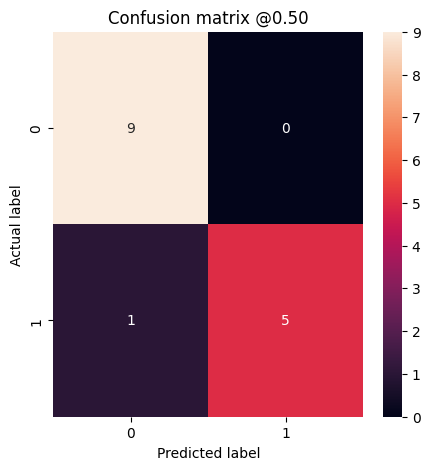

In [89]:
plot_cm(y_test, predictions_test)
plt.show()

In [90]:
#plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [91]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [92]:
#STOP

## 7 CNN Model with 16 Lines

### Dataset

In [93]:
# prepare dataset

df = df_damage_sixteen_mean.drop(columns=columns)

In [94]:
# Split into sets for training, validation, and testing + use and save scaler

X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 20)
Training labels shape: (106,) 

Validation features shape: (27, 20)
Validation labels shape: (27,) 

Test features shape: (15, 20)
Test labels shape: (15,) 



### Model

In [95]:
orig_shape = X_train.shape[1:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

in_shape = X_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))

n_classes = len(unique(y_train))
n_classes = 1
print("Classes: {0}".format(n_classes))

model = CNNModel(in_shape, n_classes)
model.summary()

Before: (20,)
After: (20, 1)
Classes: 1
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 18, 8)             32        
                                                                 
 conv1d_5 (Conv1D)           (None, 16, 16)            400       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 8, 16)            0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 8, 16)             0         
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 8)                 1032      
              

In [96]:
history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping)
#plt.plot(history.history['loss'])
#plt.show()

Epoch 1/50
4/4 [==============================] - 3s 307ms/step - loss: 0.7865 - tp: 36.0000 - fp: 39.0000 - tn: 28.0000 - fn: 18.0000 - accuracy: 0.5289 - precision: 0.4800 - recall: 0.6667 - auc: 0.6177 - prc: 0.5837 - val_loss: 0.8492 - val_tp: 9.0000 - val_fp: 16.0000 - val_tn: 1.0000 - val_fn: 1.0000 - val_accuracy: 0.3704 - val_precision: 0.3600 - val_recall: 0.9000 - val_auc: 0.6412 - val_prc: 0.5513
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 0.8041 - tp: 36.0000 - fp: 42.0000 - tn: 16.0000 - fn: 12.0000 - accuracy: 0.4906 - precision: 0.4615 - recall: 0.7500 - auc: 0.5334 - prc: 0.5160 - val_loss: 0.8410 - val_tp: 9.0000 - val_fp: 16.0000 - val_tn: 1.0000 - val_fn: 1.0000 - val_accuracy: 0.3704 - val_precision: 0.3600 - val_recall: 0.9000 - val_auc: 0.6412 - val_prc: 0.5482
Epoch 3/50
4/4 [==============================] - 0s 22ms/step - loss: 0.7697 - tp: 35.0000 - fp: 33.0000 - tn: 25.0000 - fn: 13.0000 - accuracy: 0.5660 - precision: 0.5147 - reca

Epoch 21/50
4/4 [==============================] - 0s 19ms/step - loss: 0.7897 - tp: 28.0000 - fp: 31.0000 - tn: 27.0000 - fn: 20.0000 - accuracy: 0.5189 - precision: 0.4746 - recall: 0.5833 - auc: 0.5663 - prc: 0.5586 - val_loss: 0.7358 - val_tp: 9.0000 - val_fp: 16.0000 - val_tn: 1.0000 - val_fn: 1.0000 - val_accuracy: 0.3704 - val_precision: 0.3600 - val_recall: 0.9000 - val_auc: 0.6765 - val_prc: 0.5810
Epoch 22/50
4/4 [==============================] - 0s 22ms/step - loss: 0.7371 - tp: 30.0000 - fp: 30.0000 - tn: 28.0000 - fn: 18.0000 - accuracy: 0.5472 - precision: 0.5000 - recall: 0.6250 - auc: 0.6146 - prc: 0.5757 - val_loss: 0.7321 - val_tp: 8.0000 - val_fp: 16.0000 - val_tn: 1.0000 - val_fn: 2.0000 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.8000 - val_auc: 0.6824 - val_prc: 0.5840
Epoch 23/50
4/4 [==============================] - 0s 20ms/step - loss: 0.7821 - tp: 29.0000 - fp: 33.0000 - tn: 25.0000 - fn: 19.0000 - accuracy: 0.5094 - precision: 0.4677 - re

Epoch 41/50
4/4 [==============================] - 0s 20ms/step - loss: 0.6939 - tp: 21.0000 - fp: 25.0000 - tn: 33.0000 - fn: 27.0000 - accuracy: 0.5094 - precision: 0.4565 - recall: 0.4375 - auc: 0.5708 - prc: 0.5792 - val_loss: 0.6738 - val_tp: 8.0000 - val_fp: 7.0000 - val_tn: 10.0000 - val_fn: 2.0000 - val_accuracy: 0.6667 - val_precision: 0.5333 - val_recall: 0.8000 - val_auc: 0.7294 - val_prc: 0.6102
Epoch 42/50
4/4 [==============================] - 0s 19ms/step - loss: 0.6593 - tp: 25.0000 - fp: 25.0000 - tn: 33.0000 - fn: 23.0000 - accuracy: 0.5472 - precision: 0.5000 - recall: 0.5208 - auc: 0.6182 - prc: 0.6284 - val_loss: 0.6715 - val_tp: 8.0000 - val_fp: 6.0000 - val_tn: 11.0000 - val_fn: 2.0000 - val_accuracy: 0.7037 - val_precision: 0.5714 - val_recall: 0.8000 - val_auc: 0.7353 - val_prc: 0.6120
Epoch 43/50
4/4 [==============================] - 0s 19ms/step - loss: 0.7654 - tp: 23.0000 - fp: 26.0000 - tn: 32.0000 - fn: 25.0000 - accuracy: 0.5189 - precision: 0.4694 - re

In [97]:
early_stopping.stopped_epoch

0

In [98]:
#plot_loss(history, "Bias", 0)
#plt.show()

In [99]:
#plot_metrics(history)
#plt.show()

In [100]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names(), results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_sixteen_mean.append(value)

1/1 [==============================] - 0s 22ms/step
loss :  0.8139950633049011
tp :  2.0
fp :  4.0
tn :  3.0
fn :  6.0
accuracy :  0.3333333432674408
precision :  0.3333333432674408
recall :  0.25
auc :  0.3392857313156128
prc :  0.4256861209869385


True Negatives:  3
False Positives:  4
False Negatives:  6
True Positives:  2
Total:  8


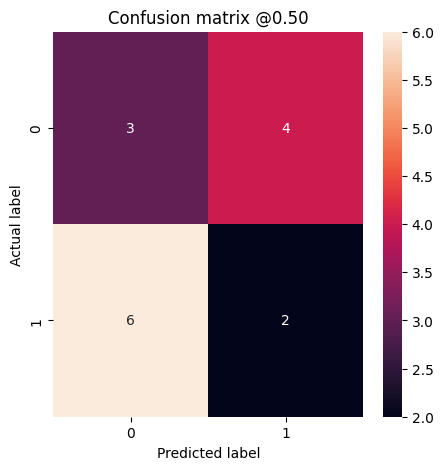

In [101]:
plot_cm(y_test, predictions_test)
plt.show()

In [102]:
#plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [103]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [104]:
#STOP

## 8 CNN Model with 32 Lines

### Dataset

In [105]:
# prepare dataset

df = df_damage_thirtytwo_mean.drop(columns=columns)

In [106]:
# Split into sets for training, validation, and testing + use and save scaler

X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 36)
Training labels shape: (106,) 

Validation features shape: (27, 36)
Validation labels shape: (27,) 

Test features shape: (15, 36)
Test labels shape: (15,) 



### Model

In [107]:
orig_shape = X_train.shape[1:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

in_shape = X_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))

n_classes = len(unique(y_train))
n_classes = 1
print("Classes: {0}".format(n_classes))

model = CNNModel(in_shape, n_classes)
model.summary()

Before: (36,)
After: (36, 1)
Classes: 1
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 34, 8)             32        
                                                                 
 conv1d_7 (Conv1D)           (None, 32, 16)            400       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 16, 16)           0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16)            0         
                                                                 
 flatten_3 (Flatten)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 8)                 2056      
              

In [108]:
history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping)
#plt.plot(history.history['loss'])
#plt.show()

Epoch 1/50
4/4 [==============================] - 2s 161ms/step - loss: 0.8996 - tp: 25.0000 - fp: 35.0000 - tn: 29.0000 - fn: 32.0000 - accuracy: 0.4463 - precision: 0.4167 - recall: 0.4386 - auc: 0.4726 - prc: 0.4623 - val_loss: 0.6741 - val_tp: 7.0000 - val_fp: 5.0000 - val_tn: 11.0000 - val_fn: 4.0000 - val_accuracy: 0.6667 - val_precision: 0.5833 - val_recall: 0.6364 - val_auc: 0.6335 - val_prc: 0.6446
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 0.7741 - tp: 27.0000 - fp: 30.0000 - tn: 27.0000 - fn: 22.0000 - accuracy: 0.5094 - precision: 0.4737 - recall: 0.5510 - auc: 0.5440 - prc: 0.5498 - val_loss: 0.6732 - val_tp: 5.0000 - val_fp: 4.0000 - val_tn: 12.0000 - val_fn: 6.0000 - val_accuracy: 0.6296 - val_precision: 0.5556 - val_recall: 0.4545 - val_auc: 0.6278 - val_prc: 0.6465
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 0.8313 - tp: 24.0000 - fp: 25.0000 - tn: 32.0000 - fn: 25.0000 - accuracy: 0.5283 - precision: 0.4898 - reca

Epoch 21/50
4/4 [==============================] - 0s 22ms/step - loss: 0.7745 - tp: 23.0000 - fp: 20.0000 - tn: 37.0000 - fn: 26.0000 - accuracy: 0.5660 - precision: 0.5349 - recall: 0.4694 - auc: 0.5283 - prc: 0.5090 - val_loss: 0.6490 - val_tp: 4.0000 - val_fp: 1.0000 - val_tn: 15.0000 - val_fn: 7.0000 - val_accuracy: 0.7037 - val_precision: 0.8000 - val_recall: 0.3636 - val_auc: 0.5597 - val_prc: 0.5996
Epoch 22/50
4/4 [==============================] - 0s 20ms/step - loss: 0.7324 - tp: 23.0000 - fp: 24.0000 - tn: 33.0000 - fn: 26.0000 - accuracy: 0.5283 - precision: 0.4894 - recall: 0.4694 - auc: 0.5428 - prc: 0.5657 - val_loss: 0.6477 - val_tp: 4.0000 - val_fp: 1.0000 - val_tn: 15.0000 - val_fn: 7.0000 - val_accuracy: 0.7037 - val_precision: 0.8000 - val_recall: 0.3636 - val_auc: 0.5568 - val_prc: 0.5985
Epoch 23/50
4/4 [==============================] - 0s 20ms/step - loss: 0.8094 - tp: 18.0000 - fp: 24.0000 - tn: 33.0000 - fn: 31.0000 - accuracy: 0.4811 - precision: 0.4286 - re

In [109]:
early_stopping.stopped_epoch

33

In [110]:
#plot_loss(history, "Bias", 0)
#plt.show()

In [111]:
#plot_metrics(history)
#plt.show()

In [112]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names(), results):
    print(name, ': ', value)
    if name == 'accuracy':
        print(value)
        accuracy_thirtytwo_mean.append(value)

1/1 [==============================] - 0s 20ms/step
loss :  0.6485836505889893
tp :  2.0
fp :  1.0
tn :  6.0
fn :  6.0
accuracy :  0.5333333611488342
0.5333333611488342
precision :  0.6666666865348816
recall :  0.25
auc :  0.6964285969734192
prc :  0.6860556602478027


True Negatives:  6
False Positives:  1
False Negatives:  6
True Positives:  2
Total:  8


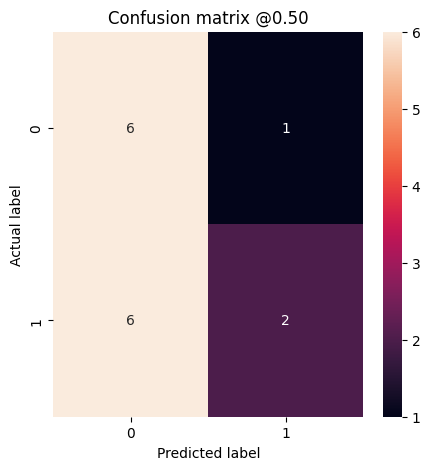

In [113]:
plot_cm(y_test, predictions_test)
plt.show()

In [114]:
#plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [115]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [116]:
#STOP

In [117]:
print(accuracy_sixteen_min_max)
print(accuracy_thirtytwo_min_max)
print(accuracy_sixteen_mean)
print(accuracy_thirtytwo_mean)

[0.9333333373069763, 0.8666666746139526]
[0.8666666746139526, 0.9333333373069763]
[0.4000000059604645, 0.3333333432674408]
[0.2666666805744171, 0.5333333611488342]


# Summarry

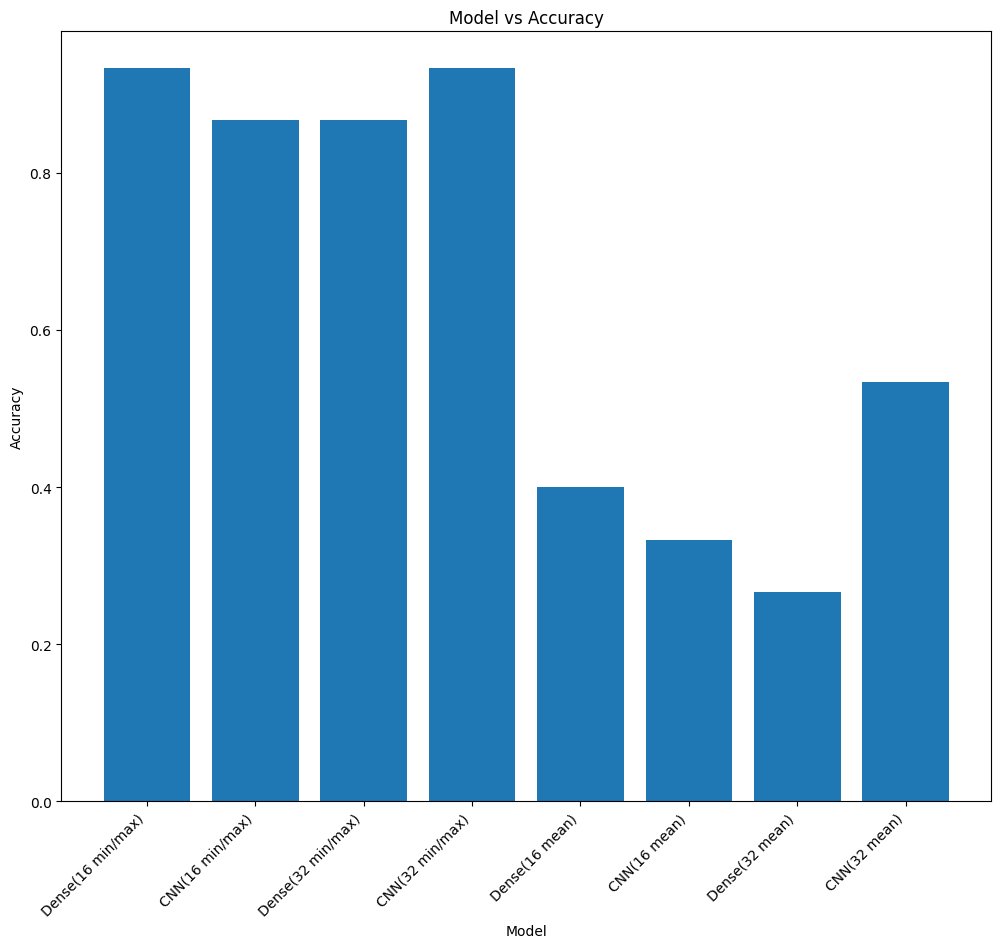

In [118]:
col = [1, 2, 3, 4, 5, 6, 7, 8]
accuracy = accuracy_sixteen_min_max + accuracy_thirtytwo_min_max + accuracy_sixteen_mean + accuracy_thirtytwo_mean

tick_label = ['Dense(16 min/max)', 'CNN(16 min/max)', 'Dense(32 min/max)', 'CNN(32 min/max)', 'Dense(16 mean)', 'CNN(16 mean)', 'Dense(32 mean)', 'CNN(32 mean)']

plt.bar(col, accuracy, tick_label = tick_label, width = 0.8)
    
plt.xticks(rotation=45, horizontalalignment="right")
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model vs Accuracy')

plt.show()   